In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='/content/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.FashionMNIST(root='/content/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]


Extracting /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]


Extracting /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]


Extracting /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]

Extracting /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



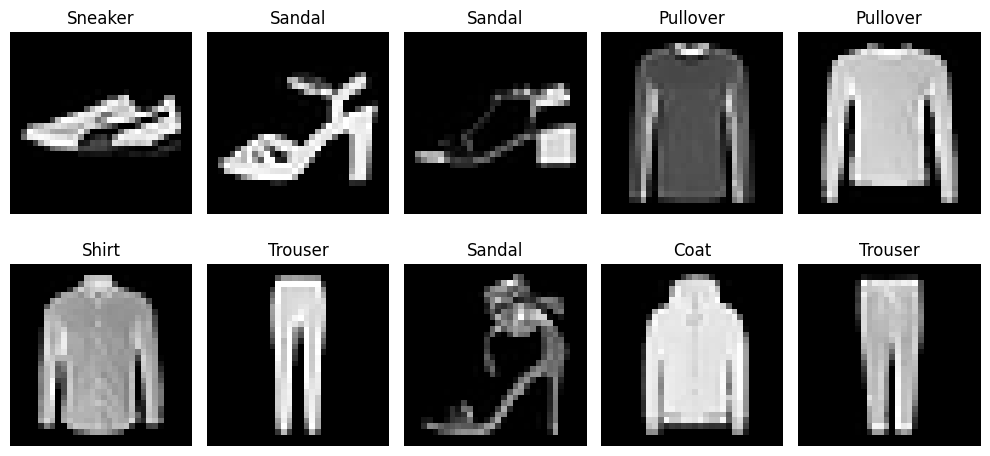

In [3]:
# Visualizing
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

def plot_sample_images(loader):
  data_iter = iter(loader)
  images, labels = next(data_iter)
  images = images.numpy()

  plt.figure(figsize=(10, 5))
  for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(class_labels[labels[i].item()])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

plot_sample_images(train_loader)

In [4]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Variational Autoencoder initialization.

        Args:
            input_shape (tuple): Shape of the input image. Default is (1, 32, 32).
            latent_dim (int): Dimension of the latent representation.
        """
        super(VAE, self).__init__()

        # ------------------
        #     1. Encoder
        # ------------------
        # This block progressively reduces the spatial dimension of the input.
        # Each Conv2D layer uses stride=2 to downsample.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), # (32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (128, 4, 4)
            nn.ReLU(),
        )

        # Dynamically calculate the flattened size after all convolution layers
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # ------------------------------------------------
        #     2. Fully Connected Layers for Latent Space
        # ------------------------------------------------

        # Two separate heads for the VAE:
        #  - fc_mu: Predicts the mean of the latent distribution
        #  - fc_logvar: Predicts the log-variance of the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent mean
        )
        self.fc_logvar = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent log variance (Hint: same dimension as mu)
        )

        # ------------------
        #     3. Decoder
        # ------------------
        # Inverts the encoder process with ConvTranspose2d (a.k.a. deconvolutions).
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size), # 128*4*4=2048
            nn.Unflatten(decode_shape[0], decode_shape[1:]), # (128, 4, 4)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # (32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # (1, 32, 32)
            nn.Sigmoid()
        )


    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick:

        z = mu + sigma * eps, where eps ~ N(0, I)

        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.

        Returns:
            z (Tensor): Latent variable sampled from N(mu, sigma^2).
        """
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)    # Sample noise from a normal distribution
        return mu + std * eps

    def calculate_flattened_size(self, model, input_shape):
       #same as the last one
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            return output.numel(), output.shape

    def forward(self, x):
        """
        Forward pass for the VAE:

        1) Encode input into latent distribution parameters (mu, logvar).
        2) Sample z using the reparameterization trick.
        3) Decode z back to a reconstructed image.

        Args:
            x (Tensor): Input images.

        Returns:
            recon_x (Tensor): Reconstructed images.
            mu (Tensor): Mean of latent distribution.
            logvar (Tensor): Log-variance of latent distribution.
            z (Tensor): Sampled latent variable.
        """
        # Encode input
        x_encoded = self.encoder(x)

        # Compute mu and logvar
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode latent vector to reconstruct the input
        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z

In [5]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = VAE()
image_test, mu, logvar, z = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"

In [6]:
#######################
# 1. Define VAE Loss
#######################
def vae_loss(recon_x, x, mu, logvar, beta=1):
    """
    Compute the Variational Autoencoder (VAE) loss function.
    A combination of:
      - Reconstruction loss (using BCE or MSE)
      - KL divergence regularizer

    Args:
      recon_x (Tensor): Reconstructed images from the decoder.
      x (Tensor): Original input images.
      mu (Tensor): Mean of the latent distribution.
      logvar (Tensor): Log-variance of the latent distribution.
      beta (float): Weight for the KL term (β-VAE concept).

    Returns:
      total_loss (Tensor): Sum of reconstruction loss and β * KL divergence.
    """

    # 1) Reconstruction Loss
    #    Measures how closely recon_x matches x.
    #    Typically use Binary Cross Entropy (BCE) if inputs are normalized [0,1].
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')


    # 2) KL Divergence
    #    Encourages the approximate posterior (q(z|x)) to be close to a
    #    standard normal prior p(z) ~ N(0,I).
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #
    # Return the total VAE loss
    return recon_loss + kl_div * beta

#######################
# 2. Training Function
#######################
def train_model(model, train_loader, val_loader, epochs, beta=1):
    """
    Trains a VAE model with a given β for the KL term.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      train_loader (DataLoader): Dataloader for training set.
      val_loader (DataLoader): Dataloader for validation set.
      epochs (int): Number of training epochs.
      beta (float): Weight for the KL divergence in the VAE loss.
    """

    # Choose an optimizer, e.g., Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-4) # e.g., 1e-4
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to train mode
        total_loss = 0

        # Use tqdm to create a progress bar
        tqdm_loader = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

        for x, _ in tqdm_loader:
            # 1) Zero out gradients from previous iteration
            optimizer.zero_grad()

            # 2) Move the batch to the correct device (CPU, CUDA, or MPS)
            x = x.to("cuda")  # Fill in your device, e.g., device, "cuda", or "mps"

            # 3) Forward pass: encode -> reparameterize -> decode
            recon_x, mu, logvar, _ = model(x)

            # 4) Compute VAE loss
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)

            # 5) Backpropagation
            loss.backward()
            # 5) update grad
            optimizer.step()

            # Accumulate total loss for this batch
            total_loss += loss.item()

            # Update tqdm progress bar with the current batch loss
            tqdm_loader.set_postfix(loss=loss.item())

        # Average loss over all training samples
        avg_train_loss = total_loss / len(train_loader.dataset)

        # Evaluate on validation data
        avg_val_loss, _ = evaluate_model(model, val_loader)

        # Print epoch statistics
        print(
            f"Epoch [{epoch + 1}/{epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}"
        )
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
    plot_training_loss(train_losses, val_losses)

In [7]:
#######################
# 3. Evaluation Function
#######################
def evaluate_model(model, loader ,beta=1):
    """
    Evaluates the VAE on a validation or test dataset.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      loader (DataLoader): Dataloader for validation/test set.

    Returns:
      avg_loss (float): Average loss across all validation samples.
      ce_loss_placeholder (float): Placeholder if you want to track
                                   additional metrics or losses.
    beta (float): Weight for the KL divergence in the VAE loss.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    ce_loss_placeholder = 0  # Example placeholder for separate metrics

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to("cuda")  # Move data to the same device as the model

            # Forward pass to get reconstruction and latent variables
            recon_x, mu, logvar, _ = model(x)

            # Compute VAE loss (without adjusting gradients)
            loss = vae_loss(recon_x, x, mu, logvar, beta=1)  # e.g., same β as training

            total_loss += loss.item()
            # Optionally compute or track other metrics here, e.g.:
            # ce_loss_placeholder += some_other_metric(...)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, ce_loss_placeholder

In [8]:
def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

Training Autoencoder...


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 68.25it/s]


Epoch [1/10], Train Loss: 369.5974, Val Loss: 299.2590


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 101.09it/s]


Epoch [2/10], Train Loss: 293.6370, Val Loss: 286.2150


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 99.94it/s]


Epoch [3/10], Train Loss: 284.6206, Val Loss: 280.1565


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 100.56it/s]


Epoch [4/10], Train Loss: 279.9398, Val Loss: 276.8049


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 79.59it/s]


Epoch [5/10], Train Loss: 277.1981, Val Loss: 274.4376


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 101.78it/s]


Epoch [6/10], Train Loss: 275.3356, Val Loss: 273.0345


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.69it/s]


Epoch [7/10], Train Loss: 273.9457, Val Loss: 271.9772


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 101.12it/s]


Epoch [8/10], Train Loss: 272.8639, Val Loss: 271.0718


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.99it/s]


Epoch [9/10], Train Loss: 272.0602, Val Loss: 270.2620


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 97.56it/s]


Epoch [10/10], Train Loss: 271.3583, Val Loss: 269.7067


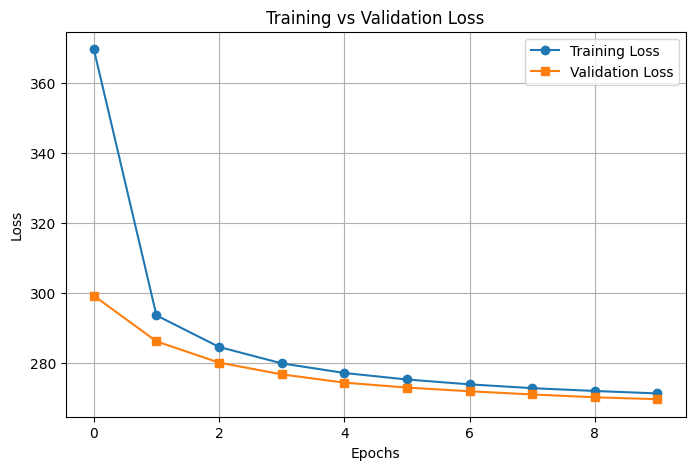

In [9]:
from tqdm import tqdm
# Train and visualize Autoencoder
vae = VAE().to("cuda")
print("Training Autoencoder...")
train_model(vae, train_loader, val_loader, epochs=10, beta =1.5)

In [13]:
path = "vae_model.pth"
torch.save(vae.state_dict(), path)
print(f"Model parameters saved to {path}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model parameters saved to vae_model.pth


In [ ]:
# # Load state dictionaries
# path= "path"
# model.load_state_dict(torch.load(path, map_location=DEVICE))
# model.eval()

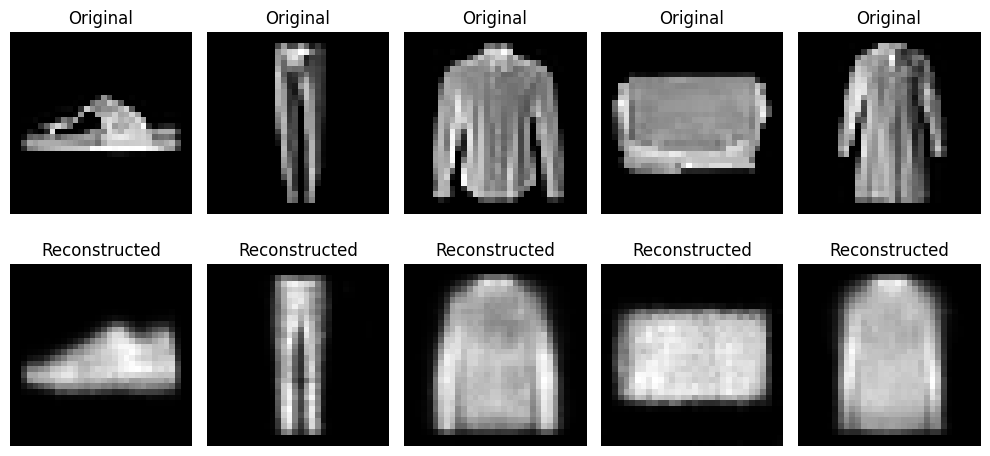

In [15]:
def plot_reconstructions(model, loader_or_z, ex=True, num_samples=5):
    """
    Plot original and reconstructed images from an Autoencoder (VAE).

    Parameters:
    - model: Trained VAE model.
    - loader_or_z: Either a DataLoader (for real images) or sampled latent vectors.
    - ex: If True, extracts a batch from DataLoader; otherwise, uses provided latent vectors.
    - num_samples: Number of images to display.

    """
    model.eval()  # Set model to evaluation mode
    model = model.to("cpu")  # Move to CPU for visualization

    with torch.no_grad():
        if ex:  # Extract batch from DataLoader
            for x, _ in loader_or_z:
                recon_x, _, _, _ = model(x)
                break
        else:  # Use provided latent vectors
            x = None  # No original images in this case
            recon_x = model.decoder(loader_or_z)
    # Convert tensors to NumPy for visualization
    if x is not None:
        x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Plot Original images (if real data was used)
        if x is not None:
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_reconstructions( vae, train_loader, ex=True)

In [19]:
embeddings = []
labels = []

vae = vae.to("cuda")  # Replace xxx with the correct device
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches
        _, mu, logvar, _ = vae(x.to("cuda"))

        latent = vae.reparameterize(mu, logvar)

        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Identify unique class labels
unique_labels = np.unique(labels)
vae=vae.to("cpu")

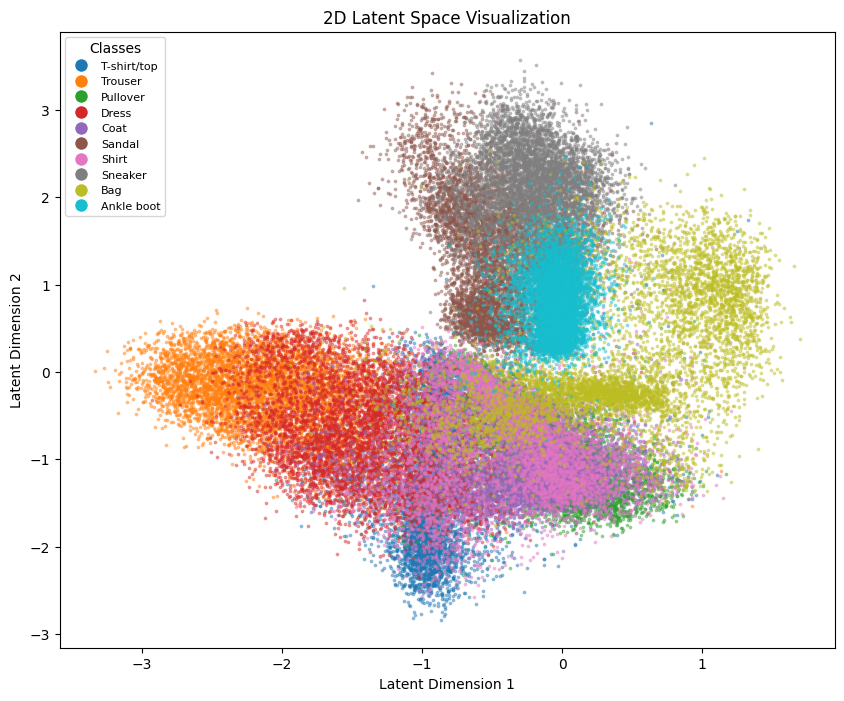

In [22]:
# Plot the 2D embeddings

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()

tensor([[ 0.2103, -0.3379],
        [ 1.4040, -0.1065],
        [ 0.4228,  0.2752],
        [ 0.2369, -1.0871],
        [-0.8995,  0.7948]])


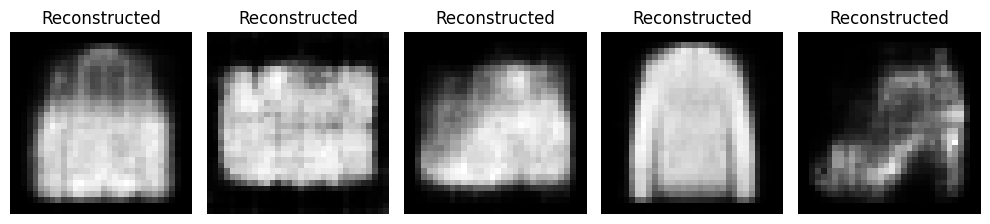

In [23]:
z_sample =  torch.tensor(np.random.normal(size=(5, 2)),dtype=torch.float32)
print(z_sample)
plot_reconstructions( vae, z_sample, ex=False)